<a href="https://colab.research.google.com/github/wangqy1216/Emotion-Prediction-in-Darkness/blob/master/EnlightenCycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorboard
# !pip install mtcnn

In [ ]:
# Install necessary packages

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import cv2
from scipy.stats import wasserstein_distance

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# from mtcnn.mtcnn import MTCNN

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
#Please download EnlightenCycleGAN from Google Drive:
# https://drive.google.com/file/d/1n7-mk_zrs2RmIrLcBNY4kOV1L5dmavu1/view?usp=sharing

In [ ]:
!unzip EnlightenCycleGAN.zip

Input Pipeline

In [ ]:
#Set parameters for image input pipeline
BUFFER_SIZE = 2048
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator()
train_data = datagen.flow_from_directory(directory='EnlightenCycleGAN', class_mode='binary', target_size=[256, 256], batch_size=BUFFER_SIZE)

Found 2120 images belonging to 2 classes.


In [ ]:
dark_samples = []
bright_samples = []

images, labels = train_data.next()

for i in range(len(images)):
  if labels[i] == 0.0:
    bright_samples.append(images[i])
  else:
    dark_samples.append(images[i])
  
dark_samples = tf.data.Dataset.from_tensor_slices(dark_samples)
bright_samples = tf.data.Dataset.from_tensor_slices(bright_samples)

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image): 
  # random brightness
  image = tf.image.random_brightness(image, 0.2)

  # random contrast
  image = tf.image.random_contrast(image, 0.75, 1.25)

  return image

In [ ]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
train_dark = dark_samples.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_bright = bright_samples.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


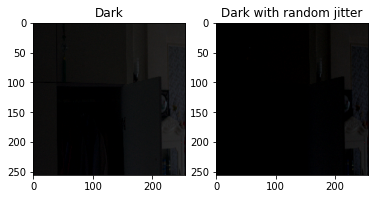

In [ ]:
sample_dark = next(iter(train_dark))
sample_bright = next(iter(train_bright))

plt.subplot(121)
plt.title('Dark')
plt.imshow(sample_dark[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Dark with random jitter')
plt.imshow(random_jitter(sample_dark[0]) * 0.5 + 0.5)

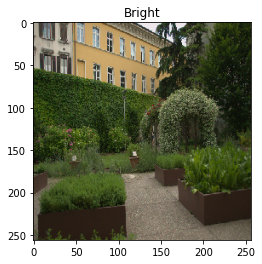

In [ ]:
plt.title('Bright')
plt.imshow(sample_bright[0] * 0.5 + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


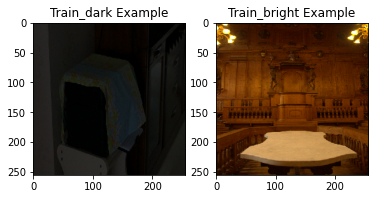

In [ ]:
plt.subplot(121)
plt.title('Train_dark Example')
plt.imshow(sample_dark[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Train_bright Example')
plt.imshow(sample_bright[0] * 0.5 + 0.5)

### CycleGAN

Generator

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_norm=True, normtype='batch'):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  
  if normtype == True and normtype == 'batch':
    result.add(tf.keras.layers.BatchNormalization())

  elif normtype == True and normtype == 'instance':
    result.add(tfa.layers.InstanceNormalization(axis=3, center=True, 
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform"))
  
  if normtyle == 'batch':
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_norm=True, layertype='transpose', normtype='batch', apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()

  if layertype == 'transpose':
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  elif layertype == 'upsampling':
    result.add(
      tf.keras.layers.UpSampling2D(size=[2, 2], interpolation='bilinear'))
    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                              kernel_initializer=initializer, use_bias=False))

  if normtype == True and normtype == 'batch':
    result.add(tf.keras.layers.BatchNormalization())

  elif normtype == True and normtype == 'instance':
    result.add(tfa.layers.InstanceNormalization(axis=3, center=True, 
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform"))

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))
  
  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Generator(output_channels):
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_norm=False), # (bs, 128, 128, 64)
    downsample(128, 4, apply_norm=True, normtype='batch'), # (bs, 64, 64, 128)
    downsample(256, 4, apply_norm=True, normtype='batch'), # (bs, 32, 32, 256)
    downsample(512, 4, apply_norm=True, normtype='batch'), # (bs, 16, 16, 512)
    downsample(512, 4, apply_norm=True, normtype='batch'), # (bs, 8, 8, 512)
    downsample(512, 4, apply_norm=True, normtype='batch'), # (bs, 4, 4, 512)
    downsample(512, 4, apply_norm=True, normtype='batch'), # (bs, 2, 2, 512)
    downsample(512, 4, apply_norm=True, normtype='batch'), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True, apply_norm=True, normtype='batch'), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True, apply_norm=True, normtype='batch'), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True, apply_norm=True, normtype='batch'), # (bs, 8, 8, 1024)
    upsample(512, 4, apply_norm=True, normtype='batch'), # (bs, 16, 16, 1024)
    upsample(256, 4, apply_norm=True, normtype='batch'), # (bs, 32, 32, 512)
    upsample(128, 4, apply_norm=True, normtype='batch'), # (bs, 64, 64, 256)
    upsample(64, 4, apply_norm=True, normtype='batch'), # (bs, 128, 128, 128)
    #upsample(32, 4), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  # last_bilinear = tf.keras.layers.UpSampling2D(size=[2, 2], interpolation='bilinear')
  # last_Conv2D = tf.keras.layers.Conv2D(output_channels, 4, strides=1, padding='same',
  #                            kernel_initializer=initializer, use_bias=False, activation='tanh');
  

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  # x = last_bilinear(x)
  # x = last_Conv2D(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

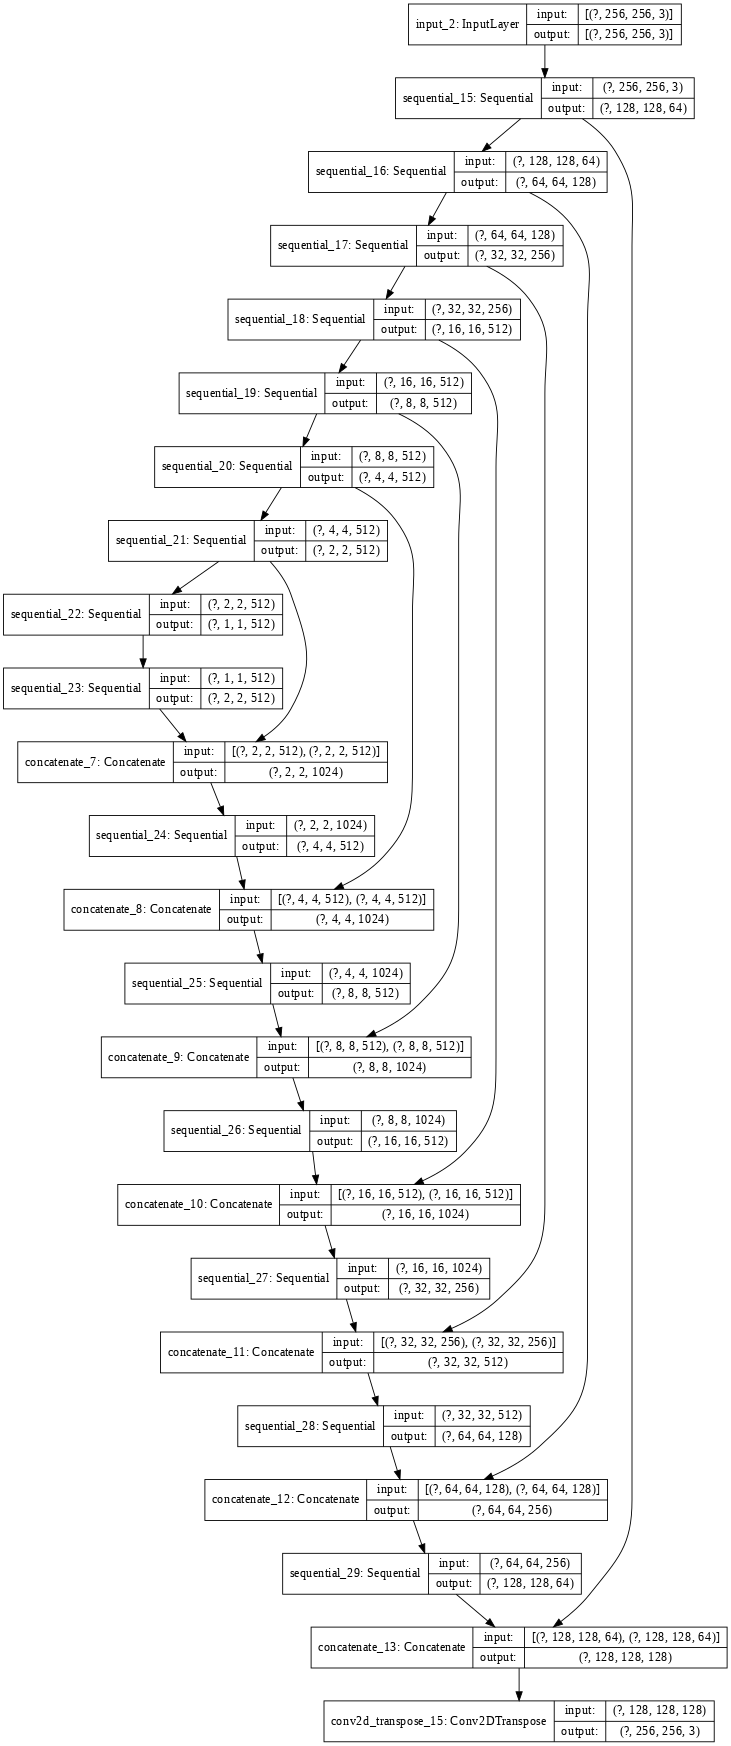

In [ ]:
generator = Generator(OUTPUT_CHANNELS)

tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

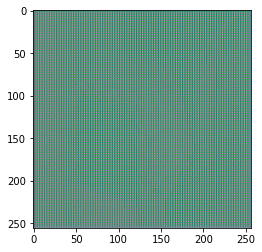

In [ ]:
gen_output = generator(sample_dark, training=False)
# gen_output = generator(img[tf.newaxis,...], training=False)
# gen_output = gen_output * 255.0
gen_output = gen_output * 0.5 + 0.5
output = tf.keras.preprocessing.image.array_to_img(
    gen_output[0], data_format=None, scale=True, dtype=None
)

plt.imshow(output)

Discriminator

In [ ]:
def Discriminator(target=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  x = inp
  
  if target:
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
  
  down1 = downsample(64, 4)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

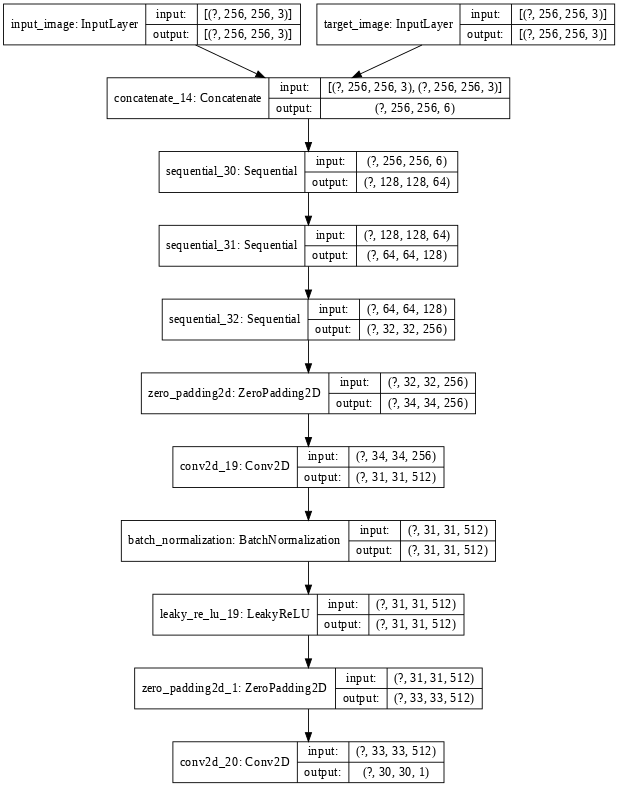

In [ ]:
discriminator = Discriminator(target=True)
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

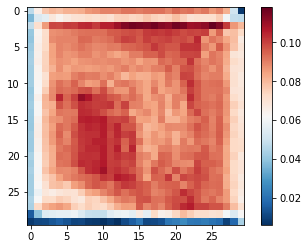

In [ ]:
disc_out = discriminator([sample_dark, gen_output], training=False)
plt.imshow(disc_out[0,...,-1], cmap='RdBu_r')
plt.colorbar()

Model

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = Generator(OUTPUT_CHANNELS)
generator_f = Generator(OUTPUT_CHANNELS)

discriminator_x = Discriminator(target=False)
discriminator_y = Discriminator(target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


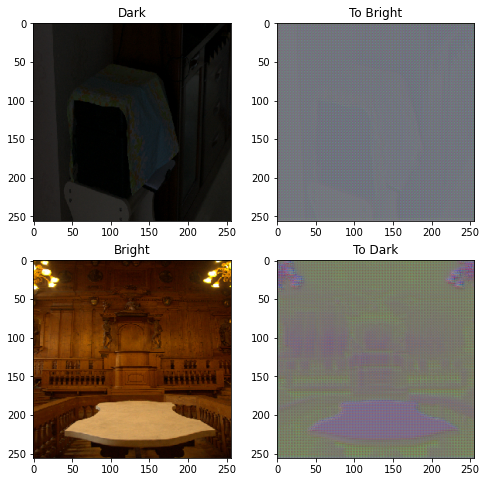

In [ ]:
to_bright = generator_g(sample_dark)
to_dark = generator_f(sample_bright)

plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_dark, to_bright, sample_bright, to_dark]
title = ['Dark', 'To Bright', 'Bright', 'To Dark']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

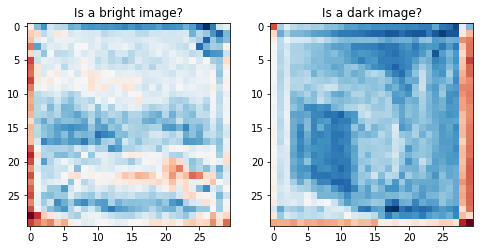

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a bright image?')
plt.imshow(discriminator_y(sample_bright)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a dark image?')
plt.imshow(discriminator_x(sample_dark)[0, ..., -1], cmap='RdBu_r')

plt.show()

### Loss Functions

In [ ]:
LAMBDA = 10

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_object(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
def edge_loss(real_image, generated_image):
  real_image = tf.image.rgb_to_grayscale(real_image)
  generated_image = tf.image.rgb_to_grayscale(generated_image)
  
  real_sobel = tf.image.sobel_edges(real_image)
  generated_sobel = tf.image.sobel_edges(generated_image)

  loss = tf.reduce_mean(tf.abs((tf.sqrt(tf.math.square(generated_sobel[...,0]) + tf.math.square(generated_sobel[...,1])) -
  tf.sqrt(tf.math.square(real_sobel[...,0]) + tf.math.square(real_sobel[...,1])))))

  return loss

In [ ]:
def value_loss(real_image, generated_image):
  real_hsv = tf.image.rgb_to_hsv(real_image)
  generated_hsv = tf.image.rgb_to_hsv(generated_image)
  
  loss = wasserstein_distance(real_image[...,2].numpy().ravel(), generated_image[...,2].numpy().ravel())

  return tf.constant(loss, tf.float32) * 5

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
content_layers = ['block1_conv2'] 
content_extractor = vgg_layers(content_layers)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
def content_loss(input_image, gen_output):
  input_content = content_extractor(input_image)
  gen_content = content_extractor(gen_output)

  loss = tf.reduce_mean((input_content - gen_content)**2)

  return loss * LAMBDA * 10

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 20)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

### Training

In [ ]:
EPOCHS = 100

In [ ]:
def generate_images(model1, model2, test_input, epoch):
  # test_input = tf.image.rgb_to_hsv(test_input)
  # test_input = tf.image.hsv_to_rgb(test_input)

  prediction = model1(test_input)
  cycle = model2(prediction)

  # cycle = tf.image.hsv_to_rgb(cycle)

  img1 = tf.cast((sample_dark[0] * 0.5 + 0.5) * 256, tf.uint8)
  img1 = tf.image.encode_jpeg(img1, quality=100)
  frame1 = tf.constant('prediction/prediction_' + str(epoch) + '.jpg')
  fwrite1 = tf.io.write_file(frame1, img1)

  img2 = tf.image.convert_image_dtype((cycle[0] * 0.5 + 0.5) * 256, tf.uint8)
  img2 = tf.image.encode_jpeg(img2, quality=100)
  frame2 = tf.constant('cycle/cycle_' + str(epoch) + '.jpg')
  fwrite2 = tf.io.write_file(frame2, img2)

    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0], cycle[0]]
  title = ['Input Image', 'Predicted Image', 'Cycled Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    if i == 0:
      plt.imshow(display_list[i] * 0.5 + 0.5)
    else:
      plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  
  plt.show()

In [ ]:
real_x = sample_dark
real_y = sample_bright

fake_y = generator_g(real_x, training=False)
cycled_x = generator_f(fake_y, training=False)

fake_x = generator_f(real_y, training=False)
cycled_y = generator_g(fake_x, training=False)


same_x = generator_f(real_x, training=False)
same_y = generator_g(real_y, training=False)

disc_real_x = discriminator_x(real_x, training=False)
disc_real_y = discriminator_y(real_y, training=False)

disc_fake_x = discriminator_x(fake_x, training=False)
disc_fake_y = discriminator_y(fake_y, training=False)


In [ ]:
print(calc_cycle_loss(real_x, cycled_x))
print(calc_cycle_loss(real_y, cycled_y))
print(generator_loss(disc_fake_y))
print(generator_loss(disc_fake_x))

print(identity_loss(real_y, same_y))
print(identity_loss(real_x, same_x))
print(discriminator_loss(disc_real_x, disc_fake_x))
print(discriminator_loss(disc_real_y, disc_fake_y))
print(content_loss(real_x, fake_y))
print(value_loss(fake_y, real_y))
print(edge_loss(fake_y, real_y))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0539953>

In [ ]:
@tf.function
def train_step(real_x, real_y, loss_matrix_pair):
  # real_x = tf.image.rgb_to_hsv(real_x)
  # real_y = tf.image.rgb_to_hsv(real_y)

  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    cont_loss = content_loss(real_x, fake_y)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y) + value_loss(real_y, fake_y) + cont_loss
    
    edge_g_loss = edge_loss(real_x, fake_y)
    edge_f_loss = edge_loss(fake_y, cycled_x)

    loss_matrix_pair['gen_g_loss'] = gen_g_loss
    loss_matrix_pair['gen_f_loss'] = gen_f_loss
    loss_matrix_pair['edge_g_loss'] = edge_g_loss
    loss_matrix_pair['edge_f_loss'] = edge_f_loss
    loss_matrix_pair['total_cycle_loss'] = total_cycle_loss

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) + edge_g_loss 
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x) + edge_f_loss

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    loss_matrix_pair['identity_loss_x'] = identity_loss(real_x, same_x)
    loss_matrix_pair['identity_loss_y'] = identity_loss(real_y, same_y)

    loss_matrix_pair['total_gen_g_loss'] = total_gen_g_loss
    loss_matrix_pair['total_gen_f_loss'] = total_gen_f_loss

    loss_matrix_pair['disc_x_loss'] = disc_x_loss
    loss_matrix_pair['disc_y_loss'] = disc_y_loss


    loss_matrix_pair['value_loss'] = value_loss(real_y, fake_y)
    loss_matrix_pair['content_loss'] = cont_loss
    # print('total_gen_g_loss: ' + str(total_gen_g_loss))
    # print('total_gen_f_loss: ' + str(total_gen_f_loss))

    # print('disc_x_loss: ' + str(disc_x_loss))
    # print('disc_y_loss: ' + str(disc_y_loss))

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

In [ ]:
def load_img(path_to_img):
 
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
  
  # img = normalize(img)
  img = tf.image.resize(img, [256, 256], method='nearest')
  img = img[tf.newaxis, :]
  return img

In [ ]:
test = load_img('Qiyu_Level1.jpg')

In [ ]:
output = generator_g(test)

plt.imshow(output[0])

In [ ]:
!mkdir generator_g
!mkdir generator_f
!mkdir discriminator_x
!mkdir discriminator_y

In [ ]:
loss_matrix_epoch = []

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  loss_matrix_vector = []  

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_dark, train_bright)):
    loss_matrix_pair = {}
    train_step(image_x, image_y, loss_matrix_pair)

    loss_matrix_vector.append(loss_matrix_pair)

    if n % 10 == 0:
      print ('.', end='')
    n+=1

  # clear_output(wait=True)
  # Using a consistent image (sample_dark) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, generator_f, test, epoch)

  loss_matrix_epoch.append(loss_matrix_vector)

  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                        ckpt_save_path))
    # generator_g.save('generator_g/generator_g_' + str(epoch) + '.h5');
    # generator_f.save('generator_f/generator_f_' + str(epoch) + '.h5');
    # discriminator_x.save('discriminator_x/discriminator_x' + str(epoch) + '.h5');
    # discriminator_y.save('discriminator_y/discriminator_y' + str(epoch) + '.h5');
    print('Saving model')
    

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start)) 

In [ ]:
list_disc_x_loss = []
list_disc_y_loss = []
list_gen_f_loss = []
list_gen_g_loss = []
list_edge_g_loss = []
list_edge_f_loss = []
list_content_loss = []
list_value_loss = []
list_total_cycle_loss = []
list_total_gen_f_loss = []
list_total_gen_g_loss = []
for epoch in loss_matrix_epoch:
  disc_x_loss = 0
  disc_y_loss = 0
  gen_f_loss = 0
  gen_g_loss = 0
  edge_g_loss = 0
  edge_f_loss = 0
  value_loss = 0
  content_loss = 0

  total_cycle_loss = 0 
  total_gen_f_loss = 0
  total_gen_g_loss = 0
  for record in epoch:
    disc_x_loss += record['disc_x_loss']
    disc_y_loss += record['disc_y_loss']
    gen_f_loss += record['gen_f_loss']
    gen_g_loss += record['gen_g_loss']
    edge_g_loss += record['edge_g_loss']
    edge_f_loss += record['edge_f_loss']
    value_loss += record['value_loss']
    content_loss += record['content_loss']

    total_cycle_loss += record['total_cycle_loss']
    total_gen_f_loss += record['total_gen_f_loss']
    total_gen_g_loss += record['total_gen_g_loss']
  
  list_disc_x_loss.append(disc_x_loss)
  list_disc_y_loss.append(disc_y_loss)
  list_gen_f_loss.append(gen_f_loss)
  list_gen_g_loss.append(gen_g_loss)
  list_edge_g_loss.append(edge_g_loss)
  list_edge_f_loss.append(edge_f_loss)
  list_value_loss.append(value_loss)
  list_content_loss.append(content_loss)

  list_total_cycle_loss.append(total_cycle_loss)
  list_total_gen_f_loss.append(total_gen_f_loss)
  list_total_gen_g_loss.append(total_gen_g_loss)

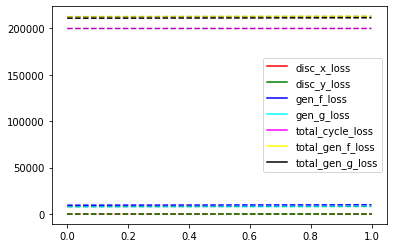

In [ ]:
# total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
# total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
# total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    
import matplotlib.lines as mlines

plt.plot(list_disc_x_loss, 'r--',
         list_disc_y_loss, 'g--',
         list_gen_f_loss, 'b--',
         list_gen_g_loss, 'c--',
         list_total_cycle_loss, 'm--',
         list_total_gen_f_loss, 'y--',
         list_total_gen_g_loss, 'k--')

red_line = mlines.Line2D([], [], color='red', label='disc_x_loss')
green_line = mlines.Line2D([], [], color='green', label='disc_y_loss')
blue_line = mlines.Line2D([], [], color='blue', label='gen_f_loss')
cyan_line = mlines.Line2D([], [], color='cyan', label='gen_g_loss')
magenta_line = mlines.Line2D([], [], color='magenta', label='total_cycle_loss')
yellow_line = mlines.Line2D([], [], color='yellow', label='total_gen_f_loss')
black_line = mlines.Line2D([], [], color='black', label='total_gen_g_loss')


plt.legend(handles=[red_line, green_line, blue_line, cyan_line, magenta_line, yellow_line, black_line])

plt.show()